### Load Library

In [100]:
import pandas as pd
from datasets import load_dataset

import string
from nltk.stem.snowball import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
from functools import lru_cache

from sklearn.model_selection import train_test_split

### Import Dataset

In [3]:
# Load the Yahoo! Answers Topic Classification dataset
dataset = load_dataset("yahoo_answers_topics")

train = dataset['train'].to_pandas()
train = train.drop(columns='id')

In [38]:
topic_mapping = {
    0: "Society & Culture",
    1: "Science & Mathematics",
    2: "Health",
    3: "Education & Reference",
    4: "Computers & Internet",
    5: "Sports",
    6: "Business & Finance",
    7: "Entertainment & Music",
    8: "Family & Relationships",
    9: "Politics & Government"
}

train['topic_name'] = train['topic'].map(topic_mapping)

## Data Wrangling

### Remove URLs from texts

In [9]:
@lru_cache(maxsize=200000)  # Cache results for frequent texts
def preprocess_text(text):
    """
    Preprocess text by removing URLs.
    """
    url_pattern = r'(?:https?:\/\/)?(?:www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b(?:[-a-zA-Z0-9()@:%_\+.~#?&\/=]*)'

    url_pattern = re.compile(url_pattern)

    return url_pattern.sub('', text)

# For processing the entire dataset at once
def batch_preprocess(texts, batch_size=20000):
    """
    Process texts in batches using parallel processing.
    """
    from concurrent.futures import ThreadPoolExecutor
    import numpy as np
    
    # Split texts into batches
    batches = np.array_split(texts, len(texts) // batch_size + 1)
    
    # Process batches in parallel
    with ThreadPoolExecutor() as executor:
        processed_batches = list(executor.map(
            lambda batch: [preprocess_text(text) for text in batch],
            batches
        ))
    
    # Flatten results
    return [text for batch in processed_batches for text in batch]


In [13]:
train.question_title = batch_preprocess(train.question_title.values)
train.question_content = batch_preprocess(train.question_content.values)
train.best_answer = batch_preprocess(train.best_answer.values)

### Remove special characters and punctuations

In [17]:
punctuation = set(string.punctuation)
# get rid of special characters
alphabet = 'abcdefghijklmnopqrstuvwxyz0123456789 '
stopwordsSet = set(stopwords.words("english"))

def clean_text(content):
    content = content.lower()
    content = ''.join([c for c in content if c not in punctuation and c in alphabet])
    content = ' '.join(w for w in content.split() if w not in stopwordsSet)
    return content

In [19]:
train.question_title = train.question_title.apply(lambda x: clean_text(x))
train.question_content = train.question_content.apply(lambda x: clean_text(x))
train.best_answer = train.best_answer.apply(lambda x: clean_text(x))

In [21]:
# Example of website rows
# pd.set_option('display.max_colwidth', None)
selected_rows = train.iloc[6:8]
selected_rows

,topic,question_title,question_content,best_answer
6,1,people blush embarrassed,people blush embarrassed,ask yahoonnblushing unique blend evolutionary ...
7,7,lin qingxia aka brigitte lin beautiful woman c...,according stephen chow true bestlooking male s...,well everyone different definition beauty like...


In [23]:
# Example of mathmatical formula rows
selected_math_rows = train.iloc[15:16]
selected_math_rows[['best_answer']]

,best_answer
15,imaginary numbers numbers squared equal negati...


In [25]:
train

,topic,question_title,question_content,best_answer
0,4,doesnt optical mouse work glass table,even surfaces,optical mice use led camera rapidly capture im...
1,5,best offroad motorcycle trail,longdistance trail throughout ca,hear mojave road amazingbr nsearch online
2,2,trans fat reduce,heard tras fat bad body find daily food,trans fats occur manufactured foods process pa...
3,6,many planes fedex,heard largest airline world,according web sitenair fleetbr n br n670 aircr...
4,6,san francisco bay area make sense rent buy,prices rent price buying make sense mostly ren...,renting vs buying depends goals br ngenerally ...
...,...,...,...,...
1399995,2,ads tv yoko etc regarding height increase use,,increased height 2 feet afterwards yesnnof cou...
1399996,6,ways sell video games,like want sell video games sell,ebay electronic boutique babbages flea markets
1399997,2,normal nots breast boobs,,normal long cancerous breasts examined every 6...
1399998,0,speak hindi,write,main hindi bol sakti


### Visualize frequent words

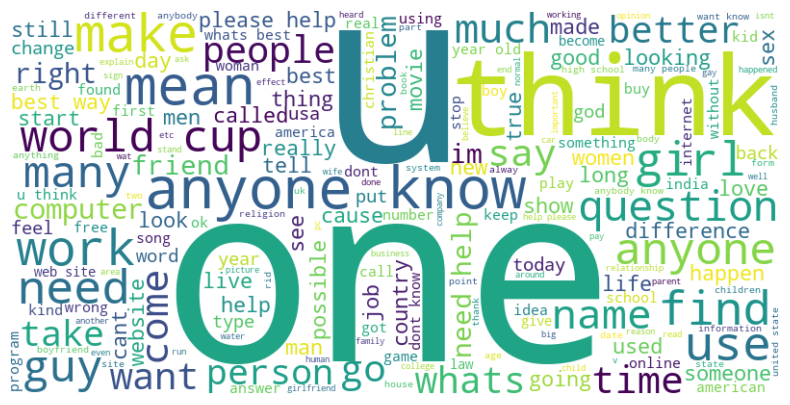

In [30]:
# Words in question title
question_titles = " ".join(s for s in train.question_title)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(question_titles)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

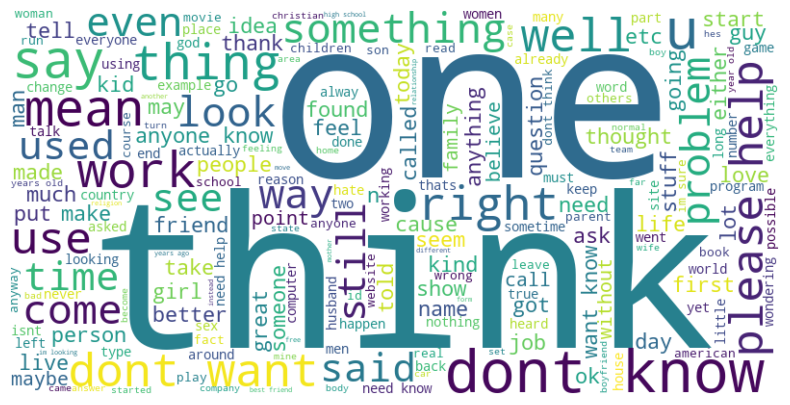

In [31]:
# Words in question content
question_contents = " ".join(s for s in train.question_content)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(question_contents)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

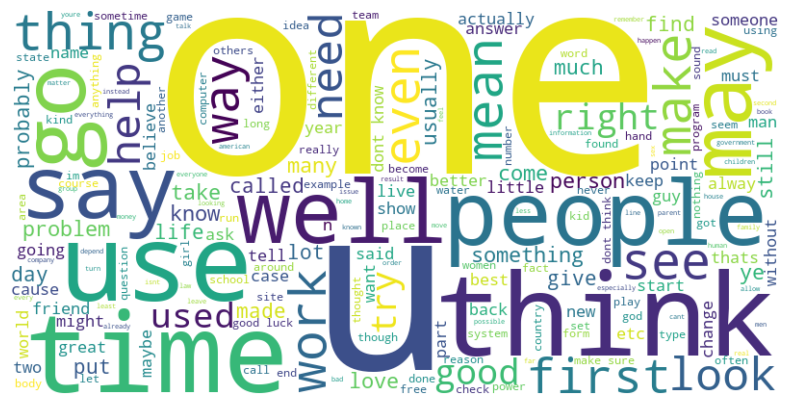

In [32]:
# Sample 20% of the words in answers
sample_answers = " ".join(s for s in train.best_answer.sample(frac=0.2, random_state=42))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(sample_answers)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [44]:
# check number of records for each topic
topic_counts = train['topic_name'].value_counts()
topic_counts

topic_name
Computers & Internet      140000
Sports                    140000
Health                    140000
Business & Finance        140000
Science & Mathematics     140000
Entertainment & Music     140000
Education & Reference     140000
Family & Relationships    140000
Politics & Government     140000
Society & Culture         140000
Name: count, dtype: int64

### Check Empty Values and Combine Columns

In [28]:
# check NaN
train_copy = train.copy()
train_copy.replace(r'^\s*$', pd.NA, regex=True, inplace=True)
nan_counts = train_copy.isna().sum()
nan_counts

topic                    0
question_title        5069
question_content    637878
best_answer          42550
dtype: int64

In [68]:
# Combine Question title and question content together
combine = train.copy()
combine['question'] = combine['question_title'] + ' ' + combine['question_content']
combine = combine.drop(columns=['question_title', 'question_content'])

In [70]:
combine

,topic,best_answer,topic_name,question
0,4,optical mice use led camera rapidly capture im...,Computers & Internet,doesnt optical mouse work glass table even sur...
1,5,hear mojave road amazingbr nsearch online,Sports,best offroad motorcycle trail longdistance tra...
2,2,trans fats occur manufactured foods process pa...,Health,trans fat reduce heard tras fat bad body find ...
3,6,according web sitenair fleetbr n br n670 aircr...,Business & Finance,many planes fedex heard largest airline world
4,6,renting vs buying depends goals br ngenerally ...,Business & Finance,san francisco bay area make sense rent buy pri...
...,...,...,...,...
1399995,2,increased height 2 feet afterwards yesnnof cou...,Health,ads tv yoko etc regarding height increase use
1399996,6,ebay electronic boutique babbages flea markets,Business & Finance,ways sell video games like want sell video gam...
1399997,2,normal long cancerous breasts examined every 6...,Health,normal nots breast boobs
1399998,0,main hindi bol sakti,Society & Culture,speak hindi write


In [72]:
combine.replace(r'^\s*$', pd.NA, regex=True, inplace=True)
nan_counts = combine.isna().sum()
nan_counts

topic              0
best_answer    42550
topic_name         0
question         625
dtype: int64

In [74]:
# drop all NaNs from train dataset
train_clean = combine.dropna()
train_clean.replace(r'^\s*$', pd.NA, regex=True, inplace=True)
nan_counts = train_clean.isna().sum()
nan_counts

C:\Users\ctric\AppData\Local\Temp\ipykernel_17784\2553255681.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_clean.replace(r'^\s*$', pd.NA, regex=True, inplace=True)


topic          0
best_answer    0
topic_name     0
question       0
dtype: int64

In [133]:
train_clean.shape

(1356901, 4)

### Check Duplicates

In [78]:
duplicate_count = train_clean.duplicated(subset=['topic', 'question', 'best_answer']).sum()
print("Number of duplicate rows:", duplicate_count)

Number of duplicate rows: 301


In [79]:
# drop duplicates
train_clean_no_duplicates = train_clean.drop_duplicates(subset=['topic', 'question', 'best_answer']).reset_index(drop=True)

In [80]:
len(train_clean_no_duplicates)

1356600

In [114]:
# check number of records for each topic
topic_counts = train_clean_no_duplicates['topic_name'].value_counts()
topic_counts = pd.DataFrame(topic_counts)

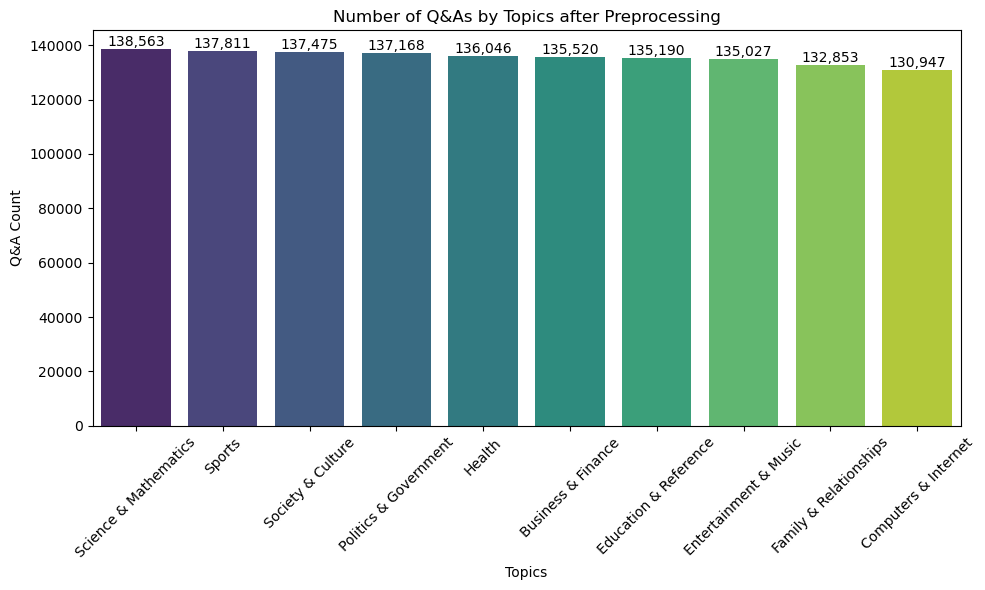

In [124]:
# Plotting the total count of MAC addresses per level
plt.figure(figsize=(10, 6))
sns.barplot(x='topic_name', y='count', hue='topic_name', data=topic_counts, palette='viridis')

plt.xlabel('Topics')
plt.ylabel('Q&A Count')
plt.title('Number of Q&As by Topics after Preprocessing')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add value labels on top of each bar
for i, v in enumerate(topic_counts['count']):
    plt.text(i, v, f'{v:,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Train test split

In [86]:
X = train_clean_no_duplicates.drop(columns=['topic', 'topic_name'])
y = train_clean_no_duplicates['topic']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [88]:
len(X_train)

1085280

In [90]:
len(y_train)

1085280

In [92]:
len(X_val)

271320

In [94]:
len(y_val)

271320

In [96]:
X_train.head()

,best_answer,question
797700,would hear know good rap studio sessions write...,class got bored made lil freestyle readin word...
1074792,tennis balls diameter two half inches two five...,diameter tennis ball golf ball someone tell di...
1082458,air naturally comes high pressure fronts low p...,question wind wind come
294723,practice playing pick games people whenever ru...,tips better soccer player
100598,quite think general international policy unite...,nonamericans many think bush war criminal hear...


In [98]:
X_val.head()

,best_answer,question
803517,200 years ago scottish historian alexander tyl...,limited government become contradiction terms ...
379914,havent met since last year,informations meeting bishop fellay society st ...
594208,yes however dont medical records doctor posses...,doctor texas charge another doctor medical rec...
43537,try following websites one irs publications ev...,need list someone selfemployed husband selfemp...
1348297,certain extend would interested anything besid...,penis become smaller man become older
